# Twitter Sentiment Analysis Pytorch

In [1]:
import numpy as np
import pandas as pd
import csv
import re
import torch
from nltk.corpus import stopwords
from gensim.parsing.porter import PorterStemmer
from gensim.utils import tokenize
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
from torchtext.legacy import data
# from torchtext import data
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from collections import Counter
from functools import reduce
! pip install captum bokeh spacy emot
import captum
import spacy
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients, LayerConductance
from captum.attr import visualization as viz
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import emot
from bokeh.io import output_notebook
output_notebook()
! python -m spacy download en_core_web_sm
nlp = spacy.load('en')
%matplotlib inline


✘ Server error (503)
Couldn't fetch available shortcuts. Please find a model for your spaCy
installation (v2.2.4), and download it manually. For more details, see the
documentation: https://spacy.io/usage/models



## Loading the data

In [2]:
!curl https://raw.githubusercontent.com/dipikabaad/Sentiment_Classification_with_RNN/master/Tweets.csv --create-dirs -o .pytorch/tweets/tweets.csv
# !mkdir checkpoint
df = pd.read_csv('.pytorch/tweets/tweets.csv')
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3341k  100 3341k    0     0  21.8M      0 --:--:-- --:--:-- --:--:-- 21.8M


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Exploring features

In [3]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [4]:
df.groupby('airline_sentiment').describe()

tweet_id                              ... retweet_count           
                     count          mean           std  ...           50%  75%   max
airline_sentiment                                       ...                         
negative            9178.0  5.692602e+17  7.572474e+14  ...           0.0  0.0  44.0
neutral             3099.0  5.691841e+17  8.068405e+14  ...           0.0  0.0  28.0
positive            2363.0  5.691006e+17  8.112476e+14  ...           0.0  0.0  22.0

[3 rows x 32 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
df[df['text'].str.len() < 2]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


In [8]:
df[df.duplicated('text')]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
331,568605449659895808,positive,0.6482,NaN,NaN,Virgin America,NaN,SuuperG,NaN,0,@VirginAmerica Thanks!,NaN,2015-02-19 18:57:58 -0800,Wandering So-Cal-ian,Pacific Time (US & Canada)
515,570299889688702976,positive,0.6634,NaN,NaN,United,NaN,nydia376,NaN,0,@united thanks,NaN,2015-02-24 11:11:04 -0800,USA,NaN
1477,569705563287896064,positive,0.6629,NaN,NaN,United,NaN,tiamariaroxs,NaN,0,@united thank you!,NaN,2015-02-22 19:49:25 -0800,NaN,NaN
1864,569545805826166784,positive,0.3512,NaN,0.0000,United,NaN,worldknits,NaN,0,@united thank you,NaN,2015-02-22 09:14:36 -0800,"Fredericksburg, VA",Eastern Time (US & Canada)
1938,569513703722393601,positive,1.0000,NaN,NaN,United,NaN,Angry_VBK,NaN,0,@united thank you,NaN,2015-02-22 07:07:02 -0800,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,569680231012773888,negative,1.0000,Customer Service Issue,1.0000,American,NaN,LBernieMeyer,NaN,0,@AmericanAir 800 number will not even let you...,NaN,2015-02-22 18:08:45 -0800,NaN,NaN
14386,569622568459636736,negative,1.0000,Customer Service Issue,0.6398,American,NaN,SchrierCar,NaN,0,@AmericanAir I want to speak to a human being!...,NaN,2015-02-22 14:19:38 -0800,NaN,NaN
14392,569621879633391616,negative,1.0000,Customer Service Issue,1.0000,American,NaN,salitron78,NaN,0,@AmericanAir no response to DM or email yet. ...,NaN,2015-02-22 14:16:53 -0800,on @TheJR,Seoul
14543,569601363799359488,negative,1.0000,Flight Attendant Complaints,1.0000,American,NaN,stevereasnors,NaN,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)


In [9]:
df.drop_duplicates('text', inplace=True)
df[df.duplicated('text')]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


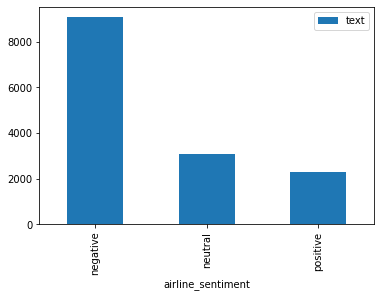

In [10]:
df[['airline_sentiment', 'text']].groupby('airline_sentiment').count().plot.bar()

### Preprocessing Data

#### Steps
1. One-hot encode output
2. Replace tags and metion with a unique symbol
3. Replace `emoji` and `emoticons` with their meaning
4. Remove stop-words
5. Remove punctuation and tokenize sentences
6. Stemming each token

In [11]:

condlist = [
    df['airline_sentiment'].str.match('neutral'),
    df['airline_sentiment'].str.match('positive'),
    df['airline_sentiment'].str.match('negative')
]
df['sentiment'] = np.select(condlist, [0,1,2])
d = df[['text', 'sentiment']]
d.head()

,text,sentiment
0,@VirginAmerica What @dhepburn said.,0
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,0
3,@VirginAmerica it's really aggressive to blast...,2
4,@VirginAmerica and it's a really big bad thing...,2


In [12]:
def emoji_helper(text):
    clean_mean = lambda x:  x.replace('-', '_').replace(':', ' ')
    for emoti in emot.emo_unicode.EMOTICONS:
        if emoti in text:
            text = text.replace(emoti, clean_mean(emot.emo_unicode.EMOTICONS.get(emoti, '')))

    for emoti in emot.emo_unicode.UNICODE_EMO:
        if emoti in text:
            text = text.replace(emoti, clean_mean(emot.emo_unicode.UNICODE_EMO.get(emoti, '')))

    for emoti in emot.emo_unicode.EMOTICONS_EMO:
        if emoti in text:
            text = text.replace(emoti, clean_mean(emot.emo_unicode.EMOTICONS_EMO.get(emoti, '')).replace(' ','_'))
    return text

porter_stemmer = PorterStemmer()


def preprocess(x):
    return [porter_stemmer.stem(word) for word in
        simple_preprocess(remove_stopwords(emoji_helper(re.sub(r'\s*([@#][\w_-]+)', '', str(x)))), deacc=True)
    ]

d['text'] = d['text'].apply(func=lambda x:preprocess(x))

d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text,sentiment
0,"[what, said]",0
1,"[plu, you, ve, ad, commerci, experi, tacki]",1
2,"[didn, todai, must, mean, need, trip]",0
3,"[it, aggress, blast, obnoxi, entertain, guest,...",2
4,"[it, big, bad, thing]",2
...,...,...
14635,"[thank, got, differ, flight, chicago]",1
14636,"[leav, minut, late, flight, no, warn, commun, ...",2
14637,"[pleas, bring, american, airlin]",0
14638,"[monei, chang, flight, don, answer, phone, ani...",2


#### Analyze review length
Here we remove the outliers

In [13]:
d['text'].str.len().describe()

count    14427.000000
mean         9.361128
std          4.221203
min          0.000000
25%          6.000000
50%         10.000000
75%         12.000000
max         49.000000
Name: text, dtype: float64

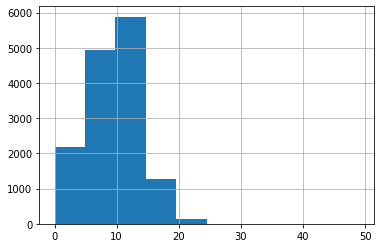

In [14]:
d['text'].str.len().hist()

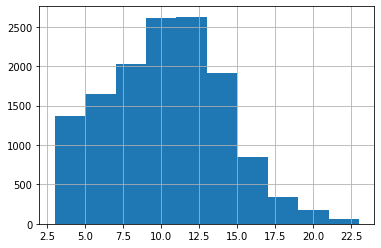

In [15]:
d = d[ (2 < d['text'].str.len()) & (d['text'].str.len() < 24) ]
d['text'].str.len().hist()

### Creating vocab

In [16]:
max_document_length = d['text'].str.len().max()  # each sentence has until 100 words
max_size = 5000
Text = data.Field(batch_first=True, tokenize=lambda x: x, include_lengths=True, fix_length=max_document_length)
Label = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
fields = [('text', Text), ('labels', Label)]

In [17]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('labels', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.sentiment
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, text_field, label_field, train_df, test_df=None, **kwargs):
        train_data, test_data = (None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, test_data) if d is not None)
test_size = 0.2 # split percentage to train\validation data
X_train,X_test,y_train,y_test = train_test_split(d['text'].index,d['sentiment'], test_size=test_size, random_state=0, stratify=d['sentiment'])
train_df = d.loc[X_train.values]
test_df = d.loc[X_test.values]
train_ds, test_ds = DataFrameDataset.splits(
    text_field=Text, label_field=Label, train_df=train_df, test_df=test_df)
vars(test_ds[0])

{'labels': 0, 'text': ['rd', 'time', 'jamaica', 'volunt', 'risk', 'youth']}

In [18]:
Text.build_vocab(train_ds, test_ds, max_size=max_size)
Label.build_vocab(train_ds)
vocab_size = len(Text.vocab)

In [19]:
PAD_IND = Text.vocab.stoi['pad']
# captum
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND) # create a reference (aka baseline) for the sentences and its constituent parts, tokens

## Defining model

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [21]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class LSTM(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers,
                 bidirectional, dropout, pad_index):
        # Constructor
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim1 = hidden_dim1
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)

        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim1,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim1 * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.SELU()
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        # activation function
        self.act = nn.Softmax() #\ F.log_softmax(outp)

    def forward(self, text, text_lengths, hid=None):
        # text = [batch size,sent_length]
        if hid == None:
            hid = self.init_hidden(text.shape[0])
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        # packed sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True) # unpad

        packed_output, (hidden, cell) = self.lstm(packed_embedded, hid)
        # packed_output shape = (batch, seq_len, num_directions * hidden_size)
        # hidden shape  = (num_layers * num_directions, batch, hidden_size)

        # concat the final forward and backward hidden state
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        # output, output_lengths = pad_packed_sequence(packed_output)  # pad the sequence to the max length in the batch
        cat = self.dropout1(cat)
        rel = self.relu(cat)
        dense1 = self.fc1(rel)

        drop = self.dropout(dense1)
        preds = self.fc2(drop)

        # Final activation function
        # preds = self.act(preds)
        # preds = preds.argmax(dim=1).unsqueeze(0)
        return preds, (hidden, cell)
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (torch.zeros(self.n_layers*2, batch_size, self.hidden_dim1).to(device),
                  torch.zeros(self.n_layers*2, batch_size, self.hidden_dim1).to(device))

        return hidden

In [22]:

# hyper-parameters:
lr = 1e-4
batch_size = 50
dropout_keep_prob = 0.5
embedding_size = 300
seed = 0
clip=5
num_classes = 3
num_hidden_nodes = 93
hidden_dim2 = 512
num_layers = 2  # LSTM layers
bi_directional = True
num_epochs = 100

pad_index = Text.vocab.stoi[Text.pad_token]

# Build the model
lstm_model = LSTM(vocab_size, embedding_size, num_hidden_nodes, hidden_dim2 , num_classes, num_layers,
                  bi_directional, dropout_keep_prob, pad_index)
lstm_model.to(device)
print(lstm_model)

LSTM(
  (embedding): Embedding(5002, 300, padding_idx=1)
  (lstm): LSTM(300, 93, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=186, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (relu): SELU()
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (act): Softmax(dim=None)
)


## training the model

In [23]:
train_iterator, test_iterator = data.BucketIterator.splits((train_ds, test_ds),
                                                           batch_size=batch_size,
                                                           sort_key=lambda x: len(x.text),
                                                           # Sort the batches by text length size
                                                           sort_within_batch=True,
                                                           device=device,
                                                           )

In [24]:
def accuracy(probs, target):
    winners = probs.argmax(dim=1)
    corrects = (winners == target)
    accuracy = corrects.sum().float() / float(target.size(0))
    return accuracy

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    h = model.init_hidden(batch_size)
    for batch in iterator:
        optimizer.zero_grad()
        # zero accumulated gradients
        model.zero_grad()
        # retrieve text and no. of words
        text, text_lengths = batch.text
        if (text.shape[0], text.shape[1]) != (batch_size, max_document_length):
            continue

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        predictions, h = model(text, text_lengths, h)
        loss = criterion(predictions, batch.labels.squeeze())

        acc = accuracy(predictions, batch.labels)

        # perform backpropagation
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    val_h = model.init_hidden(batch_size)
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            if (text.shape[0], text.shape[1]) != (batch_size, max_document_length):
                continue

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])

            predictions, val_h = model(text, text_lengths, val_h)

            loss = criterion(predictions, batch.labels)

            acc = accuracy(predictions, batch.labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def run_train(epochs, model, train_iterator, valid_iterator, optimizer, criterion):
    best_valid_loss = float('inf')

    for epoch in range(epochs):

        # train the model
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)

        # evaluate the model
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'checkpoint/twitter.t7')

        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

In [25]:
# loss function
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

In [26]:
run_train(num_epochs, lstm_model, train_iterator, test_iterator, optimizer, loss_func)

	Train Loss: 0.858 | Train Acc: 64.17%
	 Val. Loss: 0.729 |  Val. Acc: 67.89%
	Train Loss: 0.714 | Train Acc: 70.73%
	 Val. Loss: 0.658 |  Val. Acc: 70.25%
	Train Loss: 0.651 | Train Acc: 72.84%
	 Val. Loss: 0.620 |  Val. Acc: 72.25%
	Train Loss: 0.600 | Train Acc: 75.50%
	 Val. Loss: 0.593 |  Val. Acc: 73.38%
	Train Loss: 0.552 | Train Acc: 77.76%
	 Val. Loss: 0.581 |  Val. Acc: 73.96%
	Train Loss: 0.515 | Train Acc: 79.72%
	 Val. Loss: 0.576 |  Val. Acc: 74.29%
	Train Loss: 0.479 | Train Acc: 81.45%
	 Val. Loss: 0.581 |  Val. Acc: 74.62%
	Train Loss: 0.450 | Train Acc: 82.49%
	 Val. Loss: 0.577 |  Val. Acc: 75.20%
	Train Loss: 0.418 | Train Acc: 83.81%
	 Val. Loss: 0.589 |  Val. Acc: 75.24%
	Train Loss: 0.390 | Train Acc: 84.85%
	 Val. Loss: 0.615 |  Val. Acc: 74.98%
	Train Loss: 0.358 | Train Acc: 86.33%
	 Val. Loss: 0.621 |  Val. Acc: 74.76%
	Train Loss: 0.337 | Train Acc: 87.30%
	 Val. Loss: 0.637 |  Val. Acc: 75.20%
	Train Loss: 0.300 | Train Acc: 88.35%
	 Val. Loss: 0.656 |  Val

KeyboardInterrupt: ignored

In [28]:
lstm_model.load_state_dict(torch.load('checkpoint/twitter.t7', map_location=device))
# predict
test_loss, test_acc = evaluate(lstm_model, test_iterator, loss_func)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

Test Loss: 0.576 | Test Acc: 74.29%


## Visualizing the model

In [48]:
vis_data_records_ig = []
def forward(input, text_length):
    return F.softmax(lstm_model(input, text_length)[0])
lig = LayerIntegratedGradients(forward, lstm_model.embedding)
def interpret_sentence(model, sentence, min_len = max_document_length, label = 0):
    model.train()
    h = model.init_hidden(1)
    h500 = model.init_hidden(500)
    text = preprocess(sentence)
    actual_len = len(text)
    if len(text) < min_len:
        text += ['<pad>'] * (min_len - len(text))
    indexed = [Text.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    text_length = torch.tensor([actual_len], device=device)
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = F.softmax(model(input_indices, text_length, h)[0]).argmax(dim=1).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices,
                                           n_steps=500,target=2-label, return_convergence_delta=True, additional_forward_args=text_length)

    print(sentence, 'pred: ', {1:'positive', 0: 'netural', 2: 'negative'}[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)

def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()


    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
        attributions,
        pred,
        {1:'positive', 0: 'netural', 2: 'negative'}[pred_ind],
        {1:'positive', 0: 'netural', 2: 'negative'}[label],
        {1:'positive', 0: 'netural', 2: 'negative'}[label],
        attributions.sum(),
        text,
        delta))

In [53]:
interpret_sentence(lstm_model, 'It was a fantastic performance !', label=1)
interpret_sentence(lstm_model, 'Best film ever', label=1)
interpret_sentence(lstm_model, 'Such a great show!', label=1)
interpret_sentence(lstm_model, 'It was a horrible movie', label=2)
interpret_sentence(lstm_model, 'I\'ve never watched something as bad', label=2)
interpret_sentence(lstm_model, 'It is a disgusting movie!', label=2)
interpret_sentence(lstm_model, 'normal', label=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


It was a fantastic performance ! pred:  positive ( 1.00 ) , delta:  tensor([0.0249], device='cuda:0', dtype=torch.float64)
Best film ever pred:  positive ( 1.00 ) , delta:  tensor([0.0110], device='cuda:0', dtype=torch.float64)
Such a great show! pred:  positive ( 1.00 ) , delta:  tensor([0.1073], device='cuda:0', dtype=torch.float64)
It was a horrible movie pred:  negative ( 2.00 ) , delta:  tensor([0.1411], device='cuda:0', dtype=torch.float64)
I've never watched something as bad pred:  negative ( 2.00 ) , delta:  tensor([0.0352], device='cuda:0', dtype=torch.float64)
It is a disgusting movie! pred:  negative ( 2.00 ) , delta:  tensor([0.0781], device='cuda:0', dtype=torch.float64)
normal pred:  negative ( 2.00 ) , delta:  tensor([0.0033], device='cuda:0', dtype=torch.float64)


In [54]:
_ = visualization.visualize_text(vis_data_records_ig)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
positive,positive (1.00),positive,1.21,it fantast perform #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
positive,positive (1.00),positive,0.74,best film #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
positive,positive (1.00),positive,0.69,such great show #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
negative,negative (2.00),negative,-1.59,it horribl movi #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
negative,negative (2.00),negative,-0.96,ve watch bad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
negative,negative (2.00),negative,-1.59,it disgust movi #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
netural,netural (0.00),netural,1.00,normal #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
positive,positive (1.00),positive,1.20,it fantast perform #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
positive,positive (1.00),positive,0.74,best film #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad
positive,positive (1.00),positive,0.71,such great show #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad #pad


In [38]:
vis_word = []
colorlist= []
def interpret_word(model, word, min_len = max_document_length, label = 0):
    model.train()
    text = preprocess(word)
    actual_len = 1
    if len(text) < min_len:
        text += ['<pad>'] * (min_len - len(text))
    indexed = [Text.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    text_length = torch.tensor([actual_len], device=device)
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = F.softmax(model(input_indices, text_length)[0]).cpu()


    vis_word.append(pred.detach().numpy().squeeze(0))
    colorlist.append({0:'#00ff00', 1: '#00ffff', 2:'#000000' }[pred.argmax(dim=1).item()])

In [39]:
for i in Text.vocab.itos:
    interpret_word(lstm_model, i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vis_word)

In [41]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=Text.vocab.itos,
                                    color=colorlist))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                       text_font_size="8pt", text_color="#555555",
                       source=source, text_align='center',render_mode='canvas')
# p.add_layout(word_labels)

show(p)


In [42]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=Text.vocab.itos,
                                    color=colorlist))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                       text_font_size="8pt", text_color="#555555",
                       source=source, text_align='center',render_mode='canvas')
p.add_layout(word_labels)

show(p)